In [38]:
import numpy as np 
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re
import random
from sklearn.metrics import classification_report
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn import metrics

In [ ]:
# nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [2]:
df_train = pd.read_csv("drugsComTrain_raw.csv")
df_test = pd.read_csv("drugsComTest_raw.csv")
df_train['sentiment'] = df_train['rating'].apply(lambda x: 1 if x>5 else 0)
df_test['sentiment'] = df_test['rating'].apply(lambda x: 1 if x>5 else 0)

In [3]:
from tqdm import tqdm
lemmatizer=WordNetLemmatizer()

def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['review']):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
            
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)

In [4]:
from nltk.corpus import stopwords
stopword = stopwords.words('english')
negated_words = ['don',"don't",'ain','aren',"aren't",'couldn',"couldn't",
                 'didn',"didn't",'doesn',"doesn't",'hadn',"hadn't",'hasn',"hasn't",'haven',"haven't",'isn',"isn't",
                'against','no','not','no','mightn',"mightn't",'mustn',"mustn't",'needn',"needn't",'shan',"shan't",'shouldn',
                 "shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn',"wouldn't"]
stop = []
for w in stopword:
    if w not in negated_words:
        stop.append(w)

In [5]:
def clean(sen):
    return [word for word in sen if word not in stop]

In [6]:
df_train['tokens'] = clean_sentences(df_train)
df_test['tokens'] = clean_sentences(df_test)

100%|██████████████████████████████████████████████████████████████████████████| 53766/53766 [00:49<00:00, 1096.34it/s]


In [7]:
df_train['cleaned']= df_train['tokens'].apply(clean)
df_test['cleaned'] = df_test['tokens'].apply(clean)

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True,
                            ngram_range=(2,2))
train_vectors = vectorizer.fit_transform(df_train['review'])
test_vectors = vectorizer.transform(df_test['review'])

<161297x19181 sparse matrix of type '<class 'numpy.float64'>'
	with 9287308 stored elements in Compressed Sparse Row format>

In [26]:
#Accuracy using KNN Model
knn = KNeighborsClassifier(n_neighbors = 5)
t0 = time.time()
knn.fit(train_vectors, df_train['sentiment'])
t1 = time.time()
y_pred = knn.predict(test_vectors)
y_pred_train = knn.predict(train_vectors)
t2 = time.time()
print('\nK Nearest Neighbors (NN = 3)')

time_linear_train = t1-t0
time_linear_predict = t2-t1
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))



K Nearest Neighbors (NN = 3)
Training time: 0.069443s; Prediction time: 2492.345367s


In [27]:
print("TRAINING")
training_report = classification_report(df_train['sentiment'], y_pred_train)
#print('Accuracy Score: ',accuracy_score(df_train['sentiment'],y_pred_train)*100,'%',sep='')
print(training_report)

TRAINING
              precision    recall  f1-score   support

           0       0.96      0.24      0.38     48088
           1       0.75      1.00      0.86    113209

    accuracy                           0.77    161297
   macro avg       0.86      0.62      0.62    161297
weighted avg       0.82      0.77      0.72    161297



In [41]:
cm_train = metrics.confusion_matrix(df_train['sentiment'], y_pred_train)
cm_test = metrics.confusion_matrix(df_test['sentiment'], y_pred)
print("****** TRAINING ACC ****** \n")
precision_train = cm_train[1][1]/(cm_train[1][1] + cm_train[0][1])
print("\nPrecision ",precision_train)
recall_train = cm_train[1][1]/(cm_train[1][1] + cm_train[1][0])
print("\nRecall ",recall_train)
f1score_train = (2*precision_train*recall_train)/(recall_train + precision_train)
print("\nF1 Score ",f1score_train)
print("****** TESTING ACC ****** \n")
precision_test = cm_test[1][1]/(cm_test[1][1] + cm_test[0][1])
print("Precision ",precision_test)
recall_test = cm_test[1][1]/(cm_test[1][1] + cm_test[1][0])
print("\nRecall ",recall_test)
f1score_test = (2*precision_test*recall_test)/(recall_test + precision_test)
print("\nF1 Score ",f1score_test)

****** TRAINING ACC ****** 


Precision  0.7540428833215179

Recall  0.9959102191521876

F1 Score  0.8582618724094225
****** TESTING ACC ****** 

Precision  0.7089344324860698

Recall  0.9891370909768631

F1 Score  0.8259173215655325


In [29]:
print("TESTING")
testing_report = classification_report(df_test['sentiment'], y_pred, output_dict=True)
#print('Accuracy Score: ',accuracy_score(df_test['sentiment'],y_pred)*100,'%',sep='')
print(testing_report)

TESTING
{'0': {'precision': 0.7004405286343612, 'recall': 0.05886345406305917, 'f1-score': 0.10860037566167682, 'support': 16207}, '1': {'precision': 0.7089344324860698, 'recall': 0.9891370909768631, 'f1-score': 0.8259173215655325, 'support': 37559}, 'accuracy': 0.7087192649629878, 'macro avg': {'precision': 0.7046874805602155, 'recall': 0.5240002725199612, 'f1-score': 0.46725884861360467, 'support': 53766}, 'weighted avg': {'precision': 0.7063740653446674, 'recall': 0.7087192649629878, 'f1-score': 0.6096922770715439, 'support': 53766}}


In [33]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - KNN')
    plt.legend()
    plt.show()

AUC: 0.62


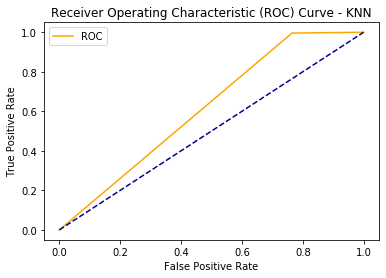

In [35]:
auc = roc_auc_score(df_train['sentiment'], y_pred_train)
print('AUC: %.2f' % auc)

fpr, tpr, thresholds = roc_curve(df_train['sentiment'], y_pred_train)

plot_roc_curve(fpr, tpr)